<a href="https://colab.research.google.com/github/dnhshl/cc-ai/blob/main/simpleRobot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# simpleRobot
Neuronales Netz zur Berechnung der inversen Kinematik eines (sehr einfachen) Roboters mit zwei Freiheitsgraden.

Wir simulieren die Freiheitsgrade eines Armes, der sich im Schultergelenk und im Ellenbogengelenk drehen kann.



## Lade notwendige Libraries


In [12]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import optimizers
from keras import losses
import matplotlib.pyplot as plt

import tensorflow.keras.backend as kb


# Daten

Generiere Trainingsdaten. Das ist hier sehr einfach, da bei bekannten Winkeln `q1` und `q2` die `x` und `y` Position berechnet werden kann. 

Der Oberarm kann im Schultergelenk ca. um einen Winkel `q1` zwischen -110 .. 20 Grad  und `q2` im Ellenbogengelenk zwischen 0 .. 90 Grad bewegt werden. Der Einfachheit halber nehmen wir weiterhin an, dass die Oberarmlänge `l1 = 30 cm` und die Unterarmlänge `l2 = 30 cm` sind.

In [2]:
a = np.array([1,2,3]) # Zeilenvektor a
b = np.array([4,5,6]) # Zeilenvektor b

M = np.vstack((a, b)) # Zusammenfassen als 2x3 Matrix

M = M.T # Transponieren -> 3x2 Matrix

print(a, b)

print(M)

sum_a_b = M.sum(axis=1) # Summe der Spaltenvektoren
print(sum_a_b)

[1 2 3] [4 5 6]
[[1 4]
 [2 5]
 [3 6]]
[5 7 9]


## Vorab: Vektoren und Matrizen in numpy



## Hilfsfunktion zur Berechnung der Vorwärts-Kinematik

In [3]:
def forward_kinematics(q):

  x = l1*tf.cos(q[:,0]) +l2*tf.cos(tf.reduce_sum(q,1))
  y = l1*tf.sin(q[:,0]) +l2*tf.sin(tf.reduce_sum(q,1))
  return tf.stack((x, y), axis=1)


## OK, jetzt also die Trainingsdaten

In [72]:
l1 = 0.3  # Länge des ersten Roboterarms
l2 = 0.3  # Länge des zweiten Roboterarms

traindatasize = 1000000 # Wie viele Traingsdaten sollen generiert werden?


def gen_data(size):

  # q1 im Bereich von -110 .. 20 Grad 
  q1 = (np.random.random_sample(size) * 130 - 110) / 180 * np.pi

  # q2 im Bereich von 0 .. 90 Grad 
  q2 = (np.random.random_sample(size) * 90) / 180 * np.pi

  # Kombiniere Vektoren als Matrix
  #dout = tf.stack((q1, q2))
  dout = np.vstack([q1,q2]).T

  # Berechne x und y
  din = forward_kinematics(dout)
  # forward_kinematics gibt einen tf Tensor zurück, wir rechnen
  # hier aber mit numpy arrays. Daher wieder zurückwandeln
  din = din.numpy()

  # Entferne nahe beieinander liegende Datenpunkte
  _, unique = np.unique(din.round(decimals=3), return_index=True, axis=0) 

  return (din[unique], dout[unique])



(din, dout) = gen_data(traindatasize)

# Da einige Datenpunkte entfernt wurden: Wieviele Trainingsdaten haben wir?

print(din.shape)

# Wir geben ein paar der Trainingsdaten aus

somedata = np.random.choice(dout.shape[0], 5)

print(dout[somedata]*180/np.pi)
print(din[somedata])





(200555, 2)
[[-108.10008448   84.8247497 ]
 [ -11.12914678   85.62660805]
 [ -18.17724293   61.31763735]
 [-108.17876698   62.64482329]
 [ -68.1483974    23.12828732]]
[[ 0.18238162 -0.40369961]
 [ 0.3745427   0.23117924]
 [ 0.50393292  0.11154924]
 [ 0.11655112 -0.49912599]
 [ 0.32371874 -0.49065177]]


## Welcher Bereich `(x, y)` kann vom Roboter erreicht werden?

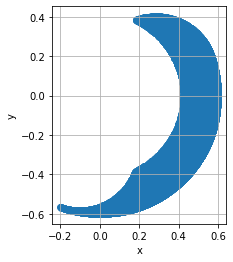

In [58]:

def plot_range():
  plt.scatter(din[:,0], din[:,1])
  plt.xlabel('x')
  plt.ylabel('y')
  #plt.xlim(0,2.5)
  plt.grid(True)
  plt.gca().set_aspect("equal")


plot_range()

# NN

Zwei Fully Connected Layer, der erste Layer mit Aktivierungsfunktion.

Als Fehlerfunktion wird der quadratische Fehler genutzt. Sie können auch [andere Loss Functions](https://keras.io/api/losses/) ausprobieren.

Testen Sie auch verschiedene [Optimizer](https://keras.io/api/optimizers/) .

## Netzwerkmodell

In [73]:
# Netzwerkparameter

layer1size = 30
layer2size = 20



In [89]:
mymodel = keras.Sequential([
      layers.Dense(layer1size, input_shape=[2,], activation='tanh'), ## Input Layer
      layers.Dense(layer2size, activation='tanh'),
      layers.Dense(2)     ## output
  ])

mymodel.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 30)                90        
_________________________________________________________________
dense_22 (Dense)             (None, 20)                620       
_________________________________________________________________
dense_23 (Dense)             (None, 2)                 42        
Total params: 752
Trainable params: 752
Non-trainable params: 0
_________________________________________________________________


## Alternative eigendefinierte Loss Funktionen

In [88]:
def myloss1(y_true,y_pred):

  in_true = forward_kinematics(y_true)
  in_pred = forward_kinematics(y_pred)

  return kb.mean(kb.square(in_true - in_pred))

def myloss2(y_true,y_pred):

  in_true = forward_kinematics(y_true)
  in_pred = forward_kinematics(y_pred)

  return kb.mean(kb.square(in_true - in_pred) + 0.01* kb.square(y_true - y_pred))


## Trainingsparameter

In [90]:
# Trainingsparameter

learning_rate = 0.01
batch_size = 50
epochs = 10
#myloss = losses.mean_squared_error
myloss = myloss2
myoptimizer = optimizers.Adam  #


In [91]:
 mymodel.compile(loss=myloss,
                optimizer=myoptimizer(learning_rate=learning_rate))

## Konstruiere NN

In [15]:
def build_and_compile_model():
  model = keras.Sequential([
      layers.Dense(layer1size, input_shape=[2,], activation='tanh', kernel_initializer='he_uniform'),
      layers.Dense(layer2size, activation='tanh',  kernel_initializer='he_uniform'),
      #layers.Dense(layer2size, activation='relu',  kernel_initializer='he_uniform'),
      layers.Dense(2, kernel_initializer='he_uniform')     ## output
  ])

  model.compile(loss=myloss,
                optimizer=myoptimizer(learning_rate=0.01))
  return model

In [16]:
mymodel = build_and_compile_model()
mymodel.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                90        
_________________________________________________________________
dense_1 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 42        
Total params: 752
Trainable params: 752
Non-trainable params: 0
_________________________________________________________________


## Trainiere Modell

Nutze 20% der Testdaten als Validierungsdatensatz

In [92]:
history = mymodel.fit(din, dout,
          batch_size=batch_size, epochs=epochs,
          validation_split = 0.2)

Epoch 1/10
3209/3209 [==============================] - 9s 3ms/step - loss: 0.0023 - val_loss: 5.9840e-04
Epoch 2/10
3209/3209 [==============================] - 8s 3ms/step - loss: 5.2253e-05 - val_loss: 4.5117e-04
Epoch 3/10
3209/3209 [==============================] - 8s 3ms/step - loss: 2.6986e-05 - val_loss: 4.7893e-04
Epoch 4/10
3209/3209 [==============================] - 8s 3ms/step - loss: 2.4983e-05 - val_loss: 4.4602e-04
Epoch 5/10
3209/3209 [==============================] - 8s 3ms/step - loss: 2.4792e-05 - val_loss: 4.9040e-04
Epoch 6/10
3209/3209 [==============================] - 8s 2ms/step - loss: 2.9200e-05 - val_loss: 4.6155e-04
Epoch 7/10
3209/3209 [==============================] - 8s 2ms/step - loss: 1.7053e-05 - val_loss: 4.0547e-04
Epoch 8/10
3209/3209 [==============================] - 8s 3ms/step - loss: 1.9536e-05 - val_loss: 4.2515e-04
Epoch 9/10
3209/3209 [==============================] - 8s 3ms/step - loss: 1.4652e-05 - val_loss: 3.9982e-04
Epoch 10/10
32

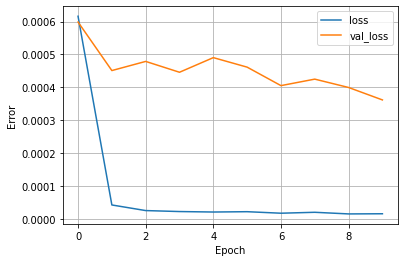

In [93]:


def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(history)

## Teste trainiertes Modell

In [94]:
testdatasize = 10000

(testdata_in, testdata_out) = gen_data(testdatasize)

print(testdata_in.shape)

predictions = mymodel.predict(testdata_in)

somedata = np.random.choice(predictions.shape[0], 5)

for d in somedata:
  print(predictions[d]*180/np.pi, testdata_out[d]*180/np.pi)

tf.print(forward_kinematics(predictions[somedata]))

tf.print(forward_kinematics(testdata_out[somedata]))

error = mymodel.evaluate(testdata_in, testdata_out, verbose=0)
print(error)

(9589, 2)
[-28.732878  60.87466 ] [-27.98332242  60.20401409]
[-69.49963   30.530298] [-69.58430334  30.81905819]
[-20.743149  45.989178] [-13.79095795  33.45136219]
[10.990316 34.232834] [11.62879188 32.71267542]
[-45.75047  69.77903] [-45.50486525  69.94766187]
[[0.51708138 0.0153868496]
 [0.338308841 -0.469672322]
 [0.551898718 0.0216980577]
 [0.505802095 0.270149559]
 [0.483338177 -0.0927347317]]
[[0.51872546334048641 0.019190189364899357]
 [0.3385640164975009 -0.46899522603519339]
 [0.57386255705867883 0.0294193060043499]
 [0.50839834687813479 0.27015096710982933]
 [0.48336706144345831 -0.089857626520828626]]
0.00020614505046978593


## Teste verschiedene Trajektorien

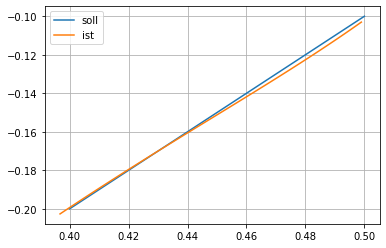

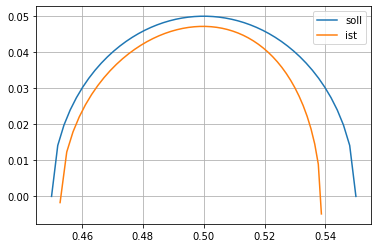

In [95]:
# Gerade

xtest1 = np.linspace(0.4,0.5)
ytest1 = (xtest1-0.4) -0.2

# Kreisbogen
xtest2 = np.linspace(-0.05, 0.05)
ytest2 = np.sqrt(0.05*0.05 - xtest2*xtest2)
xtest2 = xtest2 + 0.5
ytest2 = ytest2 


def plot_trajectory(x, y):
  plt.figure()
  plt.plot(x,y, label='soll')
  phipred = mymodel.predict(np.vstack((x, y)).T)

  # Berechne x und y
  xpred = l1 * np.cos(phipred[:,0]) + l2 * np.cos(phipred.sum(axis=1))
  ypred = l1 * np.sin(phipred[:,0]) + l2 * np.sin(phipred.sum(axis=1))

  pred = forward_kinematics(mymodel.predict(np.vstack((x, y)).T))

  plt.plot(pred[:,0], pred[:,1], label='ist')
  plt.grid(True)
  plt.legend()


plot_trajectory(xtest1, ytest1)

#plot_trajectory(xtest2, ytest2)

plot_trajectory(xtest3, ytest3)

